# prep

In [1]:
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.titlesize'] = 5

from cellpose import utils, io, models
import os

C:\Users\GlickfeldLab\anaconda3\envs\misc_test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show_segmentation_LL(fig, img, maski, flowi, channels=[0,0], file_name=None):
    """ plot segmentation results (like on website)
    
    Can save each panel of figure with file_name option. Use channels option if
    img input is not an RGB image with 3 channels.
    LL: changed subplot arrangement for wide subplots. turned off saving
    
    Parameters
    -------------

    fig: matplotlib.pyplot.figure
        figure in which to make plot

    img: 2D or 3D array
        image input into cellpose

    maski: int, 2D array
        for image k, masks[k] output from Cellpose.eval, where 0=NO masks; 1,2,...=mask labels

    flowi: int, 2D array 
        for image k, flows[k][0] output from Cellpose.eval (RGB of flows)

    channels: list of int (optional, default [0,0])
        channels used to run Cellpose, no need to use if image is RGB

    file_name: str (optional, default None)
        file name of image, if file_name is not None, figure panels are saved
        
    seg_norm: bool (optional, default False)
        improve cell visibility under labels
        

    """
    from cellpose.plot import image_to_rgb, mask_overlay

    ax = fig.add_subplot(4,1,1)
    img0 = img.copy()

    if img0.shape[0] < 4:
        img0 = np.transpose(img0, (1,2,0))
    if img0.shape[-1] < 3 or img0.ndim < 3:
        img0 = image_to_rgb(img0, channels=channels)
    else:
        if img0.max()<=50.0:
            img0 = np.uint8(np.clip(img0*255, 0, 1))
    ax.imshow(img0)
    ax.set_title('original image: stim resp dfof, gaussian filtered')
    ax.axis('off')

    outlines = utils.masks_to_outlines(maski)

    overlay = mask_overlay(img0, maski)

    ax = fig.add_subplot(4,1,2)
    outX, outY = np.nonzero(outlines)
    imgout= img0.copy()
    imgout[outX, outY] = np.array([255,0,0]) # pure red

    ax.imshow(imgout)
    ax.set_title('predicted outlines')
    ax.axis('off')

    ax = fig.add_subplot(4,1,3)
    ax.imshow(overlay)
    ax.set_title('predicted masks')
    ax.axis('off')

    ax = fig.add_subplot(4,1,4)
    ax.imshow(flowi)
    ax.set_title('predicted cell pose')
    ax.axis('off')

    # if file_name is not None:
    #     save_path = os.path.splitext(file_name)[0]
    #     io.imsave(save_path + '_overlay.jpg', overlay)
    #     io.imsave(save_path + '_outlines.jpg', imgout)
    #     io.imsave(save_path + '_flows.jpg', flowi)

# load

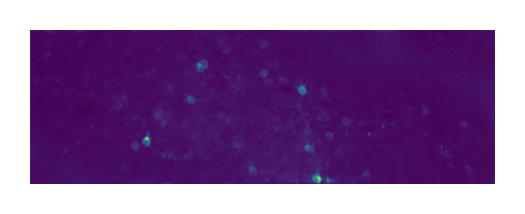

In [3]:
date = '220311'
imouse = 'i1369'
irun = '002'

# LM_i1369_220311

dir_analysis = r'Z:\All_Staff\home\lan\Analysis\2P'.replace('\\', '/')
date_imouse = date + '_' + imouse
dir_run = date_imouse + '_runs-' + irun
dir_full = os.path.join(dir_analysis, date_imouse, dir_run).replace('\\', '/')
os.chdir(dir_full)

files = ['cellpose_stim_resp_gauss.tif']
img = io.imread(files[-1])
assert img.shape == (264, 796) # confirm image shape: 30 frame/sec

plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

# run

In [4]:
model = models.Cellpose(gpu=True, model_type='cyto') # enabled gpu # TODO: enable gpu in cellpose_pymat env
channels = [[0,0]] # must be a list of lists for multiple images
diameter = 20 # can be a list for multiple images
flow_threshold = -1
cellprob_threshold = -1

for chan, filename in zip(channels, files):
    img = io.imread(filename)
    masks, flows, styles, diams = model.eval(img, diameter=None, channels=chan, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)
    io.masks_flows_to_seg(img, masks, flows, diams, filename, chan) # save npy

ncell = np.max(np.unique(masks)) # check the number of cells
print(ncell)

69


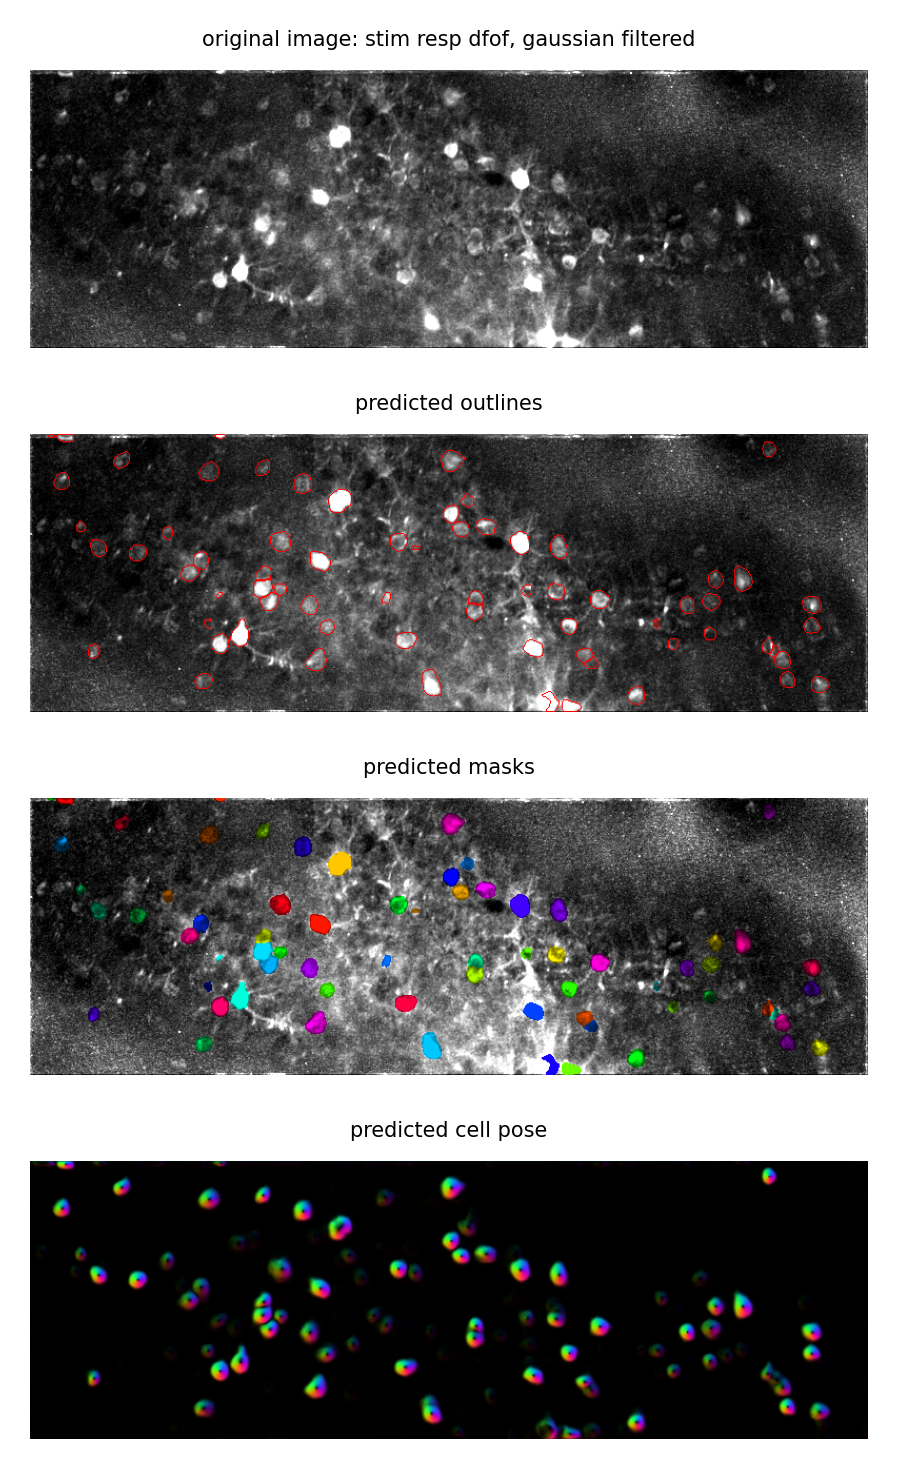

In [5]:
fig = plt.figure(figsize=(12,5))
show_segmentation_LL(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()
fig.savefig("cellpose_mask.pdf", bbox_inches='tight') # handle is fig

# compare

In [49]:
# save cellpose mask to mat
assert masks.shape == (264, 796)
sio.savemat('cellpose_mask.mat', mdict={'cellpose_mask': masks}) # todo: save to mapped drive

# load manual mask
# file_name = os.path.join(dir_analysis, date_imouse, dir_run, date_imouse + '_runs' + irun + '_mask_cell_addfake.mat')
file_name = date_imouse + '_runs-' + irun + '_mask_cell_addfake.mat'
manual_mask = sio.loadmat(file_name)
# print(manual_mask.keys())

manual_mask = manual_mask['mask_cell']
assert manual_mask.shape == (264, 796)

cellpose_mask_binary = masks.copy()
cellpose_mask_binary[cellpose_mask_binary > 0] = 1

manual_mask_binary = manual_mask.copy()
manual_mask_binary[manual_mask_binary > 0] = 1

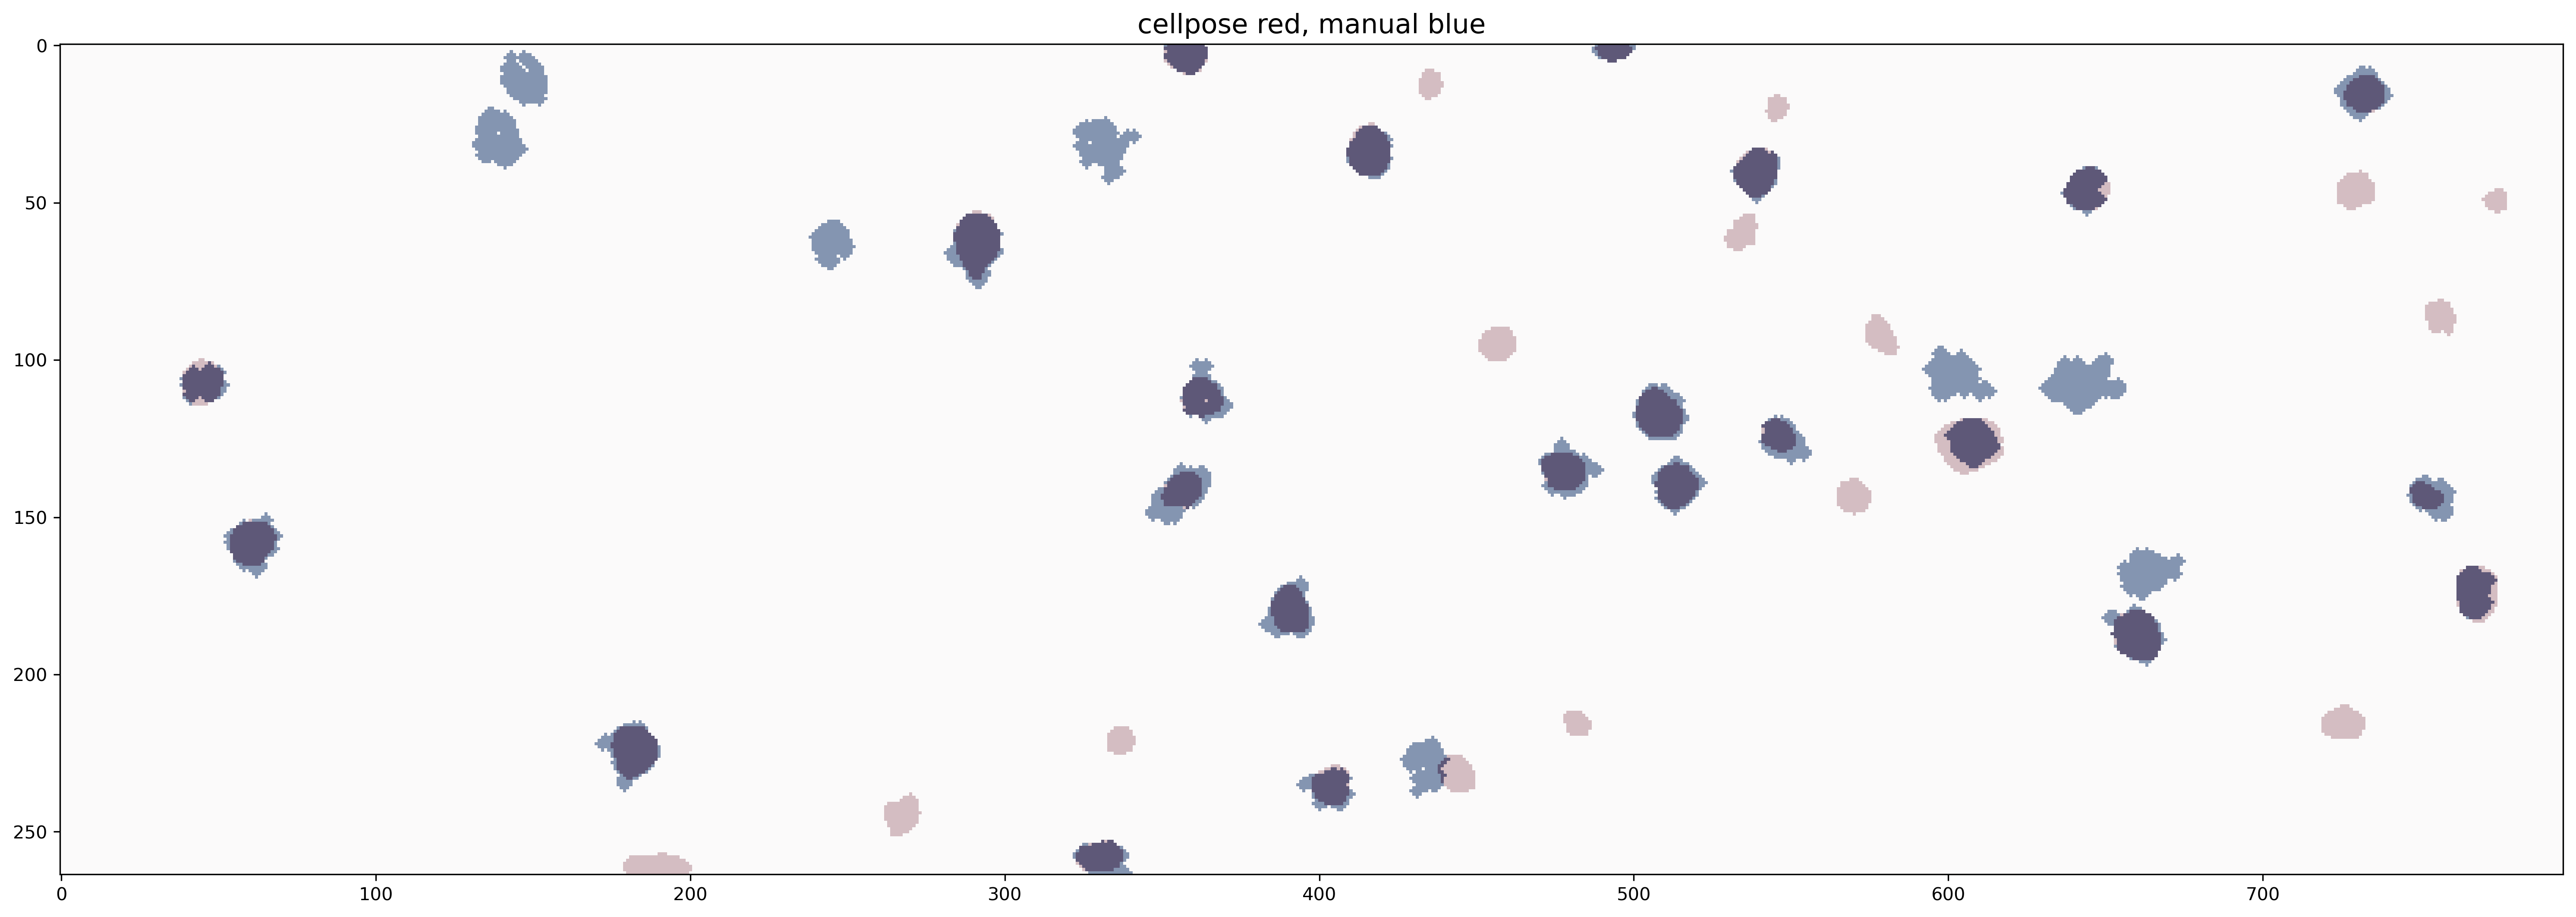

In [50]:
plt.figure(figsize=(20, 10))
plt.imshow(cellpose_mask_binary, cmap='Reds', alpha=0.5)
plt.imshow(manual_mask_binary, cmap='Blues', alpha=0.5)
plt.title('cellpose red, manual blue', fontsize=15)

plt.tight_layout()
plt.savefig("cellpose_compare_manual_mask.pdf", bbox_inches='tight')